# **复制 Momentum 策略**
## **- by Kent Daniel, Tobias J. Moskowitz， 2016**

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

import warnings
warnings.filterwarnings('ignore')

In [4]:
crsp = pd.read_csv('E:/Replications/MoM/1925-2018data.csv', dtype={'PERMNO': str})
cols_keep = ['PERMNO','date', 'SHRCD', 'EXCHCD', 'DLRET', 'PRC', 'RET', 'SHROUT']
crsp = crsp[cols_keep]
#crsp = crsp.sort_values(['date', 'PERMNO'], ascending=True)
#crsp = crsp.reset_index(drop = True)
crsp.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-01-31,10.0,3.0,NaN,-4.3750,C,3680.0
2,10000,1986-02-28,10.0,3.0,NaN,-3.2500,-0.257143,3680.0
3,10000,1986-03-31,10.0,3.0,NaN,-4.4375,0.365385,3680.0
4,10000,1986-04-30,10.0,3.0,NaN,-4.0000,-0.098592,3793.0


In [5]:
# 用-99填充na，然后将数据类型转换为int
crsp[["SHRCD", "EXCHCD", "SHROUT"]] = crsp[["SHRCD", "EXCHCD", "SHROUT"]].fillna(-99)
crsp[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]] = crsp[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]].astype(int)

In [6]:
# 过滤数据
# 替换 -99 为 NaN
crsp.replace([-99], np.nan, inplace = True)
# 转换日期格式
crsp["date"] = pd.to_datetime(crsp["date"], errors='coerce')
# 筛选三大交易所的数据以及普通股
crsp = crsp[(crsp['EXCHCD'].isin([1, 2, 3])) & (crsp['SHRCD'].isin([10, 11]))]
print(crsp.dtypes)

PERMNO             int32
date      datetime64[ns]
SHRCD            float64
EXCHCD           float64
DLRET             object
PRC              float64
RET               object
SHROUT           float64
dtype: object


In [7]:
# 设置为最后交易日历日
crsp["date"] = crsp["date"] + pd.offsets.MonthEnd(0)

# 设置年、月两个新列
crsp.loc[:,"Year"] = crsp["date"].dt.year
crsp.loc[:,"Month"] = crsp["date"].dt.month
crsp.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,Year,Month
1,10000,1986-01-31,10.0,3.0,NaN,-4.37500,C,3680.0,1986,1
2,10000,1986-02-28,10.0,3.0,NaN,-3.25000,-0.257143,3680.0,1986,2
3,10000,1986-03-31,10.0,3.0,NaN,-4.43750,0.365385,3680.0,1986,3
4,10000,1986-04-30,10.0,3.0,NaN,-4.00000,-0.098592,3793.0,1986,4
5,10000,1986-05-31,10.0,3.0,NaN,-3.10938,-0.222656,3793.0,1986,5


#### **1. 计算滞后市值（lagged market capitalization, MKTCAP_lag）**
市值 Market Capitalization  计算方式：
$$MKTCAP=∣PRC∣×SHROUT$$
其中 PRC 是股价，SHROUT 是股票流通量。  
另外计算滞后一期的市值 MKTCAP_lag（即 t-1 期的市值），以用于后续横截面回归分析。

In [9]:
# 计算市值、滞后1期市值
crsp["MKTCAP"] = np.abs(crsp["PRC"]) * crsp["SHROUT"]
crsp["MKTCAP_lag"] = crsp.groupby(["PERMNO"], group_keys=False)["MKTCAP"].shift(1)
crsp["MKTCAP_lag"] = crsp["MKTCAP_lag"] / 1000
crsp.head(6)

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,Year,Month,MKTCAP,MKTCAP_lag
1,10000,1986-01-31,10.0,3.0,NaN,-4.37500,C,3680.0,1986,1,16100.00000,NaN
2,10000,1986-02-28,10.0,3.0,NaN,-3.25000,-0.257143,3680.0,1986,2,11960.00000,16.100000
3,10000,1986-03-31,10.0,3.0,NaN,-4.43750,0.365385,3680.0,1986,3,16330.00000,11.960000
4,10000,1986-04-30,10.0,3.0,NaN,-4.00000,-0.098592,3793.0,1986,4,15172.00000,16.330000
5,10000,1986-05-31,10.0,3.0,NaN,-3.10938,-0.222656,3793.0,1986,5,11793.87834,15.172000
6,10000,1986-06-30,10.0,3.0,NaN,-3.09375,-0.005025,3793.0,1986,6,11734.59375,11.793878


#### **2. 计算累积股息调整收益（CRET）**
在股票市场中，个股的总收益不仅包括普通的价格变动收益（RET），还需要考虑由于现金红利导致的回报（DLRET）。  
因此，定义累积股息调整收益（CRET），以确保收益数据的完整性：
- 检查 RET 和 DLRET 是否都存在（非缺失值）。
    - 若有缺失，使用 RET 作为 CRET；
    - 若 RET 和 DLRET 都可用，则采用 累积复利计算：
$$CRET=(1+RET)×(1+DLRET)−1$$

In [11]:
# 将字段中的字母替换为 NaN
crsp.replace(["A", "S", "C", "T", "P"], np.nan, inplace = True)
# 转换收益数据为浮点
crsp["RET"] = crsp["RET"].astype(float)

# 用稀释因子调整收益率，确保收益率反映实际的投资回报。
Ret = crsp["RET"]
Ret = np.where(crsp["RET"].notna() & crsp["DLRET"].notna(), (crsp["DLRET"].astype(float) + 1)*(crsp["RET"] + 1) - 1, Ret)
crsp["Ret"] = Ret
crsp.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,Year,Month,MKTCAP,MKTCAP_lag,Ret
1,10000,1986-01-31,10.0,3.0,NaN,-4.37500,NaN,3680.0,1986,1,16100.00000,NaN,NaN
2,10000,1986-02-28,10.0,3.0,NaN,-3.25000,-0.257143,3680.0,1986,2,11960.00000,16.100,-0.257143
3,10000,1986-03-31,10.0,3.0,NaN,-4.43750,0.365385,3680.0,1986,3,16330.00000,11.960,0.365385
4,10000,1986-04-30,10.0,3.0,NaN,-4.00000,-0.098592,3793.0,1986,4,15172.00000,16.330,-0.098592
5,10000,1986-05-31,10.0,3.0,NaN,-3.10938,-0.222656,3793.0,1986,5,11793.87834,15.172,-0.222656


#### **3. 计算用于排序的收益率（Ranking Return, Ranking_Ret）**
个股在过去 t-12 到 t-2 期 的累积收益率：
- 首先获取 shift_log_ret，即 CRET 在 t-2 期的滞后收益。
- 然后利用 滚动窗口计算对数收益率的累积和（rolling sum of log returns）：
$$Ranking\_Ret = \sum_{i=t-12}^{t-2} \log(1 + prev\_RET)$$

“总计”意味着每家公司的累计回报（1+回报）是从第t-12个月到第t-2个月的累积对数。

这一步的目的是构造历史收益率变量，使我们能够根据过去收益率的表现对个股进行排序，以便研究 **动量效应(Momentum Effect)** 等现象。

In [13]:
# 创建排序用的回报列、计算对数回报 
crsp_temp = crsp[['PERMNO','date','RET']].sort_values(['PERMNO','date']).set_index('date')
crsp_temp["logret"] = np.log(1 + crsp_temp.RET)
# 滞后两期处理 
crsp_temp["shift_log_ret"] = crsp_temp.groupby(["PERMNO"], group_keys=False)["logret"].shift(2)

# 计算累计对数回报
cum_ret = crsp_temp.groupby(["PERMNO"], group_keys=False)["shift_log_ret"].rolling(11).sum()
# 重置索引、重命名、合并数据
cum_ret = cum_ret.reset_index().rename(columns = {"shift_log_ret" : "Ranking_Ret"})
crsp = pd.merge(crsp, cum_ret, on = ["PERMNO", "date"])
crsp.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,Year,Month,MKTCAP,MKTCAP_lag,Ret,Ranking_Ret
0,10000,1986-01-31,10.0,3.0,NaN,-4.37500,NaN,3680.0,1986,1,16100.00000,NaN,NaN,NaN
1,10000,1986-02-28,10.0,3.0,NaN,-3.25000,-0.257143,3680.0,1986,2,11960.00000,16.100,-0.257143,NaN
2,10000,1986-03-31,10.0,3.0,NaN,-4.43750,0.365385,3680.0,1986,3,16330.00000,11.960,0.365385,NaN
3,10000,1986-04-30,10.0,3.0,NaN,-4.00000,-0.098592,3793.0,1986,4,15172.00000,16.330,-0.098592,NaN
4,10000,1986-05-31,10.0,3.0,NaN,-3.10938,-0.222656,3793.0,1986,5,11793.87834,15.172,-0.222656,NaN


#### **4. 选取重要的滞后变量**
需要使用过去的股价和收益率数据来预测未来收益。因此提取：
- PRC_T：t-13 期（即过去13个月前）的股价 PRC；
- RET_T：t-2 期（即2个月前）的累积股息调整收益 CRET。

#### **5. 检查是否无缺失、满足至少8个月数据**
为了确保股票在样本期间的可交易性，再引入一个名为 valid_indicator：
1. 确保过去 12 个月前的价格、过去2个月回报无缺失。
2. 过去11个月中至少有8个月的有效数据，否则认为该样本不可靠。

这一步可以有效去除数据缺失过多的个股，减少因数据不足导致的回归偏误。

In [16]:
def data_filter(df):
    tmp_ret = df['Ranking_Ret']
    # 指示符向量，长度等于输入df的行数
    valid_indicator = np.ones(df.shape[0])
    # 查看无缺失
    valid_indicator[np.isnan(df.PRC.shift(13))] = np.nan 
    valid_indicator[np.isnan(df.RET.shift(2))] = np.nan    
    valid_indicator[np.isnan(df.MKTCAP_lag)] = np.nan
    # 检查是否满足过去11个月有8个月回报数据
    valid_indicator[np.isnan(df.Ret.shift(1)).rolling(11).sum() > 3] = np.nan
    # 更新有效回报
    valid_return = valid_indicator*tmp_ret
    
    return valid_return

out = crsp.groupby(["PERMNO"], group_keys=False).apply(data_filter)

In [17]:
# 根据过滤后的数据更新排序变量
crsp.Ranking_Ret = out.reset_index(0, drop=True)
crsp1 = crsp.copy()
crsp1.tail()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,Year,Month,MKTCAP,MKTCAP_lag,Ret,Ranking_Ret
3543249,93436,2018-08-31,11.0,3.0,NaN,301.66000,0.011806,170593.0,2018,8,5.146108e+07,50860.598726,0.011806,0.058479
3543250,93436,2018-09-30,11.0,3.0,NaN,264.76999,-0.122290,171578.0,2018,9,4.542871e+07,51461.084380,-0.122290,-0.177086
3543251,93436,2018-10-31,11.0,3.0,NaN,337.32001,0.274011,171733.0,2018,10,5.792898e+07,45428.705344,0.274011,-0.122874
3543252,93436,2018-11-30,11.0,3.0,NaN,350.48001,0.039013,171733.0,2018,11,6.018898e+07,57928.977277,0.039013,-0.224856
3543253,93436,2018-12-31,11.0,3.0,NaN,332.79999,-0.050445,172602.0,2018,12,5.744194e+07,60188.983557,-0.050445,0.088176


In [18]:
# 筛选列、排序、设置样本区间
crsp1 = crsp1[["Year", "Month", "PERMNO", "EXCHCD", "MKTCAP_lag", "Ret", "Ranking_Ret"]]
crsp1 = crsp1.sort_values(['Year', 'Month'])
crsp1 = crsp1[crsp1.Year >= 1927]
crsp1.reset_index(drop=True)

,Year,Month,PERMNO,EXCHCD,MKTCAP_lag,Ret,Ranking_Ret
0,1927,1,10006,1.0,60.900000,-0.013547,NaN
1,1927,1,10014,1.0,1.837500,NaN,NaN
2,1927,1,10022,1.0,11.424000,-0.075893,0.111727
3,1927,1,10030,1.0,21.450000,0.009545,0.009212
4,1927,1,10057,1.0,3.062500,-0.051020,-0.896088
...,...,...,...,...,...,...,...
3536405,2018,12,93422,1.0,1901.271130,-0.298879,-0.080821
3536406,2018,12,93423,1.0,5179.949840,-0.093383,-0.158845
3536407,2018,12,93426,1.0,422.394570,-0.109048,0.158268
3536408,2018,12,93434,3.0,91.341250,-0.341818,-0.194157


#### **6. 计算全市场的十分位排名 DM_decile**

按照 Ranking_Ret 计算 全市场 的十分位分组（Decile）。

In [20]:
crsp1 = crsp1.dropna(subset = 'Ranking_Ret')
crsp1["DM_decile"] = crsp1.groupby(["Year", "Month"], group_keys = False)["Ranking_Ret"].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
crsp1

,Year,Month,PERMNO,EXCHCD,MKTCAP_lag,Ret,Ranking_Ret,DM_decile
3766,1927,1,10022,1.0,11.424000,-0.075893,0.111727,8
5525,1927,1,10030,1.0,21.450000,0.009545,0.009212,6
9486,1927,1,10057,1.0,3.062500,-0.051020,-0.896088,1
11338,1927,1,10073,1.0,1.276500,0.094595,-0.559615,2
12577,1927,1,10081,1.0,5.960000,-0.075000,-0.543634,2
...,...,...,...,...,...,...,...,...
3542512,2018,12,93422,1.0,1901.271130,-0.298879,-0.080821,5
3542615,2018,12,93423,1.0,5179.949840,-0.093383,-0.158845,4
3542717,2018,12,93426,1.0,422.394570,-0.109048,0.158268,8
3543126,2018,12,93434,3.0,91.341250,-0.341818,-0.194157,4


#### **7. 计算仅针对 NYSE 股票的十分位排名 KRF_decile**

仅对 EXCHCD == 1 的股票计算十分位数，并用于分类其他股票。

In [22]:
# 筛选列、排序、设置样本区间
crsp2 = crsp.copy()
crsp2 = crsp2[["Year", "Month", "PERMNO", "EXCHCD", "MKTCAP_lag", "Ret", "Ranking_Ret"]]
crsp2 = crsp2.sort_values(['Year', 'Month'])
crsp2 = crsp2[crsp2.Year >= 1927]
crsp2.reset_index(drop=True)

nyse = crsp2[crsp2['EXCHCD']==1]
nyse = nyse.dropna(subset = 'Ranking_Ret')
nyse["KRF_decile"] = nyse.groupby(["Year", "Month"], group_keys = False)["Ranking_Ret"].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
nyse

,Year,Month,PERMNO,EXCHCD,MKTCAP_lag,Ret,Ranking_Ret,KRF_decile
3766,1927,1,10022,1.0,11.424000,-0.075893,0.111727,8
5525,1927,1,10030,1.0,21.450000,0.009545,0.009212,6
9486,1927,1,10057,1.0,3.062500,-0.051020,-0.896088,1
11338,1927,1,10073,1.0,1.276500,0.094595,-0.559615,2
12577,1927,1,10081,1.0,5.960000,-0.075000,-0.543634,2
...,...,...,...,...,...,...,...,...
3541462,2018,12,93384,1.0,27.184593,-0.297110,-2.924719,1
3542410,2018,12,93420,1.0,2273.618760,-0.225490,-0.016757,6
3542512,2018,12,93422,1.0,1901.271130,-0.298879,-0.080821,5
3542615,2018,12,93423,1.0,5179.949840,-0.093383,-0.158845,4


In [23]:
crsp1["KRF_decile"] = nyse.reset_index().KRF_decile
crsp1

,Year,Month,PERMNO,EXCHCD,MKTCAP_lag,Ret,Ranking_Ret,DM_decile,KRF_decile
3766,1927,1,10022,1.0,11.424000,-0.075893,0.111727,8,5.0
5525,1927,1,10030,1.0,21.450000,0.009545,0.009212,6,2.0
9486,1927,1,10057,1.0,3.062500,-0.051020,-0.896088,1,5.0
11338,1927,1,10073,1.0,1.276500,0.094595,-0.559615,2,1.0
12577,1927,1,10081,1.0,5.960000,-0.075000,-0.543634,2,6.0
...,...,...,...,...,...,...,...,...,...
3542512,2018,12,93422,1.0,1901.271130,-0.298879,-0.080821,5,NaN
3542615,2018,12,93423,1.0,5179.949840,-0.093383,-0.158845,4,NaN
3542717,2018,12,93426,1.0,422.394570,-0.109048,0.158268,8,NaN
3543126,2018,12,93434,3.0,91.341250,-0.341818,-0.194157,4,NaN


由于KRF十分位数不能覆盖全部库存，为了提高准确性，观察到谁的KRF十分位数为NA，使KRF十分位数等于DM十分位数。

In [25]:
crsp1['KRF_decile'] = crsp1['KRF_decile'].fillna(crsp1['DM_decile'])
crsp1['KRF_decile'] = crsp1['KRF_decile'].astype('int64')
crsp1

,Year,Month,PERMNO,EXCHCD,MKTCAP_lag,Ret,Ranking_Ret,DM_decile,KRF_decile
3766,1927,1,10022,1.0,11.424000,-0.075893,0.111727,8,5
5525,1927,1,10030,1.0,21.450000,0.009545,0.009212,6,2
9486,1927,1,10057,1.0,3.062500,-0.051020,-0.896088,1,5
11338,1927,1,10073,1.0,1.276500,0.094595,-0.559615,2,1
12577,1927,1,10081,1.0,5.960000,-0.075000,-0.543634,2,6
...,...,...,...,...,...,...,...,...,...
3542512,2018,12,93422,1.0,1901.271130,-0.298879,-0.080821,5,5
3542615,2018,12,93423,1.0,5179.949840,-0.093383,-0.158845,4,4
3542717,2018,12,93426,1.0,422.394570,-0.109048,0.158268,8,8
3543126,2018,12,93434,3.0,91.341250,-0.341818,-0.194157,4,4


#### **8. 计算分组加权收益**
- 计算权重：MKTCAP_lag / sum(MKTCAP_lag)。
- 计算加权收益：使用 np.average() 按 Ret 计算加权平均值。

In [27]:
ff_mkt = pd.read_csv('E:/Replications/MoM/F-F_Research_Data_Factors.csv', names = ['date', 'Market_minus_Rf', 'SMB', 'HML', 'RF'], skiprows = 1)

ff_mkt["date"] = pd.to_datetime(ff_mkt["date"], format = "%Y%m")
ff_mkt["date"] = ff_mkt["date"] + pd.offsets.MonthEnd(0)

ff_mkt["Year"] = ff_mkt.date.dt.year
ff_mkt["Month"] = ff_mkt.date.dt.month

ff_mkt[["Market_minus_Rf", "SMB", "HML", "RF"]] = ff_mkt[["Market_minus_Rf", "SMB", "HML", "RF"]] / 100
ff_mkt = ff_mkt.query("Year >= 1927 and Year <=2018")
ff_mkt

,date,Market_minus_Rf,SMB,HML,RF,Year,Month
6,1927-01-31,-0.0006,-0.0037,0.0454,0.0025,1927,1
7,1927-02-28,0.0418,0.0004,0.0294,0.0026,1927,2
8,1927-03-31,0.0013,-0.0165,-0.0261,0.0030,1927,3
9,1927-04-30,0.0046,0.0030,0.0081,0.0025,1927,4
10,1927-05-31,0.0544,0.0153,0.0473,0.0030,1927,5
...,...,...,...,...,...,...,...
1105,2018-08-31,0.0344,0.0115,-0.0400,0.0016,2018,8
1106,2018-09-30,0.0006,-0.0229,-0.0171,0.0015,2018,9
1107,2018-10-31,-0.0768,-0.0474,0.0340,0.0019,2018,10
1108,2018-11-30,0.0169,-0.0068,0.0028,0.0018,2018,11


In [28]:
def decile_weighted_return(df):
    mktcap_lag = df.MKTCAP_lag.sum()
    weights = df.MKTCAP_lag / mktcap_lag
    weighted_ret = weights * df.Ret
    return weighted_ret.sum()

#### **9. 计算超额收益**
- 计算 DM_Ret - Rf，得到超额收益。
- 选取 DM_decile==10 和 DM_decile==1 的收益率，计算两者的差值。

In [30]:
# 计算分组收益 
out3 = crsp1.groupby(["DM_decile", "Year", "Month"]).apply(decile_weighted_return)
out3 = out3.reset_index([0,1,2]).rename(columns = {0 : "DM_Ret"})

out4 = crsp1.groupby(["KRF_decile", "Year", "Month"]).apply(decile_weighted_return)
out4 = out4.reset_index([0,1,2]).rename(columns = {0 : "KRF_Ret"})

# 合并数据
out_df = out3.join(out4.KRF_Ret) 
# 加入无风险利率列
out_df = pd.merge(out_df, ff_mkt[["Year", "Month", "RF", "Market_minus_Rf"]], how='outer')
out_df = out_df.rename(columns = {'DM_decile' : 'decile'})
out_df

,decile,Year,Month,DM_Ret,KRF_Ret,RF,Market_minus_Rf
0,1,1927,1,-0.032149,0.008597,0.0025,-0.0006
1,2,1927,1,-0.039637,0.002488,0.0025,-0.0006
2,3,1927,1,0.019708,0.006209,0.0025,-0.0006
3,4,1927,1,0.004212,0.008426,0.0025,-0.0006
4,5,1927,1,-0.005908,-0.011606,0.0025,-0.0006
...,...,...,...,...,...,...,...
11035,6,2018,12,-0.104088,-0.101695,0.0020,-0.0957
11036,7,2018,12,-0.084941,-0.090859,0.0020,-0.0957
11037,8,2018,12,-0.085731,-0.096270,0.0020,-0.0957
11038,9,2018,12,-0.086134,-0.084703,0.0020,-0.0957


In [31]:
# 筛选 日期至 2013.3
out_df = out_df.query("Year <= 2013")
out_df = out_df[:len(out_df)-90]

# 计算超额收益
out_df['DM_exe_ret'] = out_df['DM_Ret'] - out_df['RF']
out_df['KRF_exe_ret'] = out_df['KRF_Ret'] - out_df['RF']
out_df

,decile,Year,Month,DM_Ret,KRF_Ret,RF,Market_minus_Rf,DM_exe_ret,KRF_exe_ret
0,1,1927,1,-0.032149,0.008597,0.0025,-0.0006,-0.034649,0.006097
1,2,1927,1,-0.039637,0.002488,0.0025,-0.0006,-0.042137,-0.000012
2,3,1927,1,0.019708,0.006209,0.0025,-0.0006,0.017208,0.003709
3,4,1927,1,0.004212,0.008426,0.0025,-0.0006,0.001712,0.005926
4,5,1927,1,-0.005908,-0.011606,0.0025,-0.0006,-0.008408,-0.014106
...,...,...,...,...,...,...,...,...,...
10345,6,2013,3,0.043526,0.045672,0.0000,0.0403,0.043526,0.045672
10346,7,2013,3,0.034656,0.033958,0.0000,0.0403,0.034656,0.033958
10347,8,2013,3,0.048755,0.044435,0.0000,0.0403,0.048755,0.044435
10348,9,2013,3,0.054364,0.053639,0.0000,0.0403,0.054364,0.053639


#### **10. 计算每个分位数组合的统计值、计算 WML 组合（赢家-输家）**
- groupby('DM_decile') 按照分位数分组。
- **计算年化超额收益、标准差、夏普比率和偏度**。

In [33]:
# 计算描述性统计
r_rf = out_df.groupby(['decile'])['DM_exe_ret'].apply(np.mean)*12
decile_vol = out_df.groupby(['decile'])['DM_Ret'].apply(np.std)*np.sqrt(12)
decile_sr = r_rf/decile_vol
decile_skew = out_df.groupby(['decile'])['DM_Ret'].apply(lambda x: skew(np.log(1+x)))

In [34]:
# 计算赢家-输家多空组合收益
loser_decile = out_df.groupby(['decile']).get_group(1)
winner_decile = out_df.groupby(['decile']).get_group(10)

WML = np.array(winner_decile.DM_Ret) - np.array(loser_decile.DM_Ret) + np.array(winner_decile.RF)
WML_r = np.mean(WML - np.array(winner_decile.RF))*12
WML_vol = WML.std()*np.sqrt(12)
WML_SR = WML_r/WML_vol
WML_skew = skew(np.log(1+WML))

In [35]:
r_rf = np.append(np.array(r_rf), WML_r)
decile_vol = np.append(np.array(decile_vol), WML_vol)
decile_sr = np.append(np.array(decile_sr), WML_SR)
decile_skew = np.append(np.array(decile_skew), WML_skew)
num_array = np.round(np.array([r_rf*100, decile_vol*100, decile_sr, decile_skew]), 2)

In [36]:
# 生成数据框
colnames = ["Decile 1", "Decile 2", "Decile 3", "Decile 4", "Decile 5", "Decile 6", "Decile 7", "Decile 8", "Decile 9", "Decile 10", "WML"]
    
out_df2 = pd.DataFrame(num_array, columns= colnames, index=['r-rf', 'σ', 'SR', 'sk(m)'])
out_df2

,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
r-rf,-2.45,2.76,2.98,6.43,7.16,7.12,9.14,10.31,11.31,15.43,17.88
σ,36.55,30.56,25.91,23.06,21.53,20.32,19.39,19.10,20.39,23.76,30.01
SR,-0.07,0.09,0.11,0.28,0.33,0.35,0.47,0.54,0.55,0.65,0.60
sk(m),0.12,-0.10,-0.17,0.15,-0.09,-0.23,-0.48,-0.54,-0.76,-0.80,-5.13


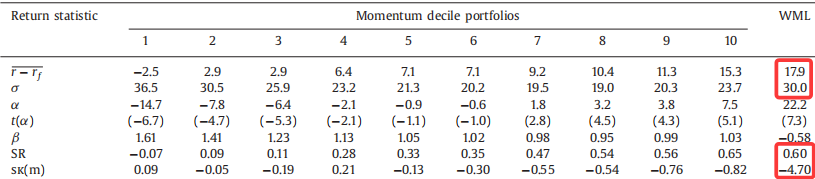

## **4.25 补齐表格结果**

In [39]:
num_array1 = np.round(np.array([r_rf*100, decile_vol*100]), 2)

In [40]:
# 生成数据框
colnames = ["Decile 1", "Decile 2", "Decile 3", "Decile 4", "Decile 5", "Decile 6", "Decile 7", "Decile 8", "Decile 9", "Decile 10", "WML"]
    
out_df2 = pd.DataFrame(num_array1, columns= colnames, index=['r-rf', 'σ'])
out_df2

,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
r-rf,-2.45,2.76,2.98,6.43,7.16,7.12,9.14,10.31,11.31,15.43,17.88
σ,36.55,30.56,25.91,23.06,21.53,20.32,19.39,19.10,20.39,23.76,30.01


In [41]:
alpha_list = []
t_alpha_list = []
beta_list = []
# 构造组合列表：decile 1~10 + WML
decile_list = list(range(1, 11))
decile_list.append("WML")

for dec in decile_list:
    if dec == "WML":
        temp = winner_decile.copy()
        temp["WML_exe_ret"] = WML - temp["RF"]  # 与 market excess return 同维度
        y = temp["WML_exe_ret"]
        x = temp["Market_minus_Rf"]
    else:
        # 单个 decile
        df_dec = out_df[out_df["decile"] == dec]
        y = df_dec["DM_exe_ret"]
        x = df_dec["Market_minus_Rf"]
    
    # 回归
    X = sm.add_constant(x)
    model = OLS(y, X, missing="drop").fit()
    
    alpha_list.append(model.params[0] * 12 *100)          # 年化 alpha
    t_alpha_list.append(model.tvalues[0])                 # t 值
    beta_list.append(model.params[1]) 

In [42]:
# 两个原始指标 + 三个新指标
out_df2.loc["α"] = np.round(alpha_list, 2)
out_df2.loc["t(α)"] = np.round(t_alpha_list, 2)
out_df2.loc["β"] = np.round(beta_list, 2)
out_df2

,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
r-rf,-2.45,2.76,2.98,6.43,7.16,7.12,9.14,10.31,11.31,15.43,17.88
σ,36.55,30.56,25.91,23.06,21.53,20.32,19.39,19.10,20.39,23.76,30.01
α,-14.72,-7.96,-6.41,-2.10,-0.95,-0.71,1.69,3.08,3.81,7.52,22.24
t(α),-6.70,-4.88,-5.22,-2.12,-1.15,-1.09,2.67,4.36,4.25,5.18,7.35
β,1.62,1.41,1.24,1.12,1.07,1.03,0.98,0.95,0.99,1.04,-0.57


In [43]:
num_array2 = np.round(np.array([decile_sr, decile_skew]), 2)
out_df3 = pd.DataFrame(num_array2, columns= colnames, index=['SR', 'SK(m)'])
out_df3

,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
SR,-0.07,0.09,0.11,0.28,0.33,0.35,0.47,0.54,0.55,0.65,0.60
SK(m),0.12,-0.10,-0.17,0.15,-0.09,-0.23,-0.48,-0.54,-0.76,-0.80,-5.13


In [44]:
# 纵向拼接
combined_df = pd.concat([out_df2, out_df3], axis=0)
combined_df.loc["t(α)"] = combined_df.loc["t(α)"].apply(lambda x: f"({x:.1f})")
combined_df

,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
r-rf,-2.45,2.76,2.98,6.43,7.16,7.12,9.14,10.31,11.31,15.43,17.88
σ,36.55,30.56,25.91,23.06,21.53,20.32,19.39,19.1,20.39,23.76,30.01
α,-14.72,-7.96,-6.41,-2.1,-0.95,-0.71,1.69,3.08,3.81,7.52,22.24
t(α),(-6.7),(-4.9),(-5.2),(-2.1),(-1.1),(-1.1),(2.7),(4.4),(4.2),(5.2),(7.3)
β,1.62,1.41,1.24,1.12,1.07,1.03,0.98,0.95,0.99,1.04,-0.57
SR,-0.07,0.09,0.11,0.28,0.33,0.35,0.47,0.54,0.55,0.65,0.6
SK(m),0.12,-0.1,-0.17,0.15,-0.09,-0.23,-0.48,-0.54,-0.76,-0.8,-5.13


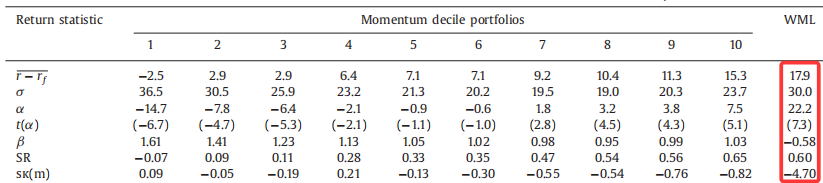

In [104]:
# 定义开始日期
start_date = '1927-01-01' 
n_months = len(WML) 

# 转换为 Series，添加月份索引
WML_series = pd.Series(WML, index=pd.date_range(start=start_date, periods=n_months, freq='M'))
cum_returns = (1 + WML_series).cumprod()
# 历史峰值
rolling_max = cum_returns.cummax()
# 回撤序列
drawdowns = cum_returns / rolling_max - 1
# 找到回撤序列中最小值（即最大回撤）的位置。
max_dd_idx = drawdowns.idxmin()
# 找到最大回撤发生前的累计回报峰值位置
peak_idx = cum_returns[:max_dd_idx + pd.offsets.MonthEnd(0)].idxmax()

In [106]:
print(f"最大回撤: {drawdowns.min():.2%}")
print(f"最大回撤发生时间: {max_dd_idx.date()}\n最大回撤对应峰值位置：{peak_idx.date()}")

最大回撤: -95.15%
最大回撤发生时间: 1939-09-30
最大回撤对应峰值位置：1932-05-31


- 特性：反映动量策略的绝对收益，具有显著的正偏度（长期正收益）但极端负偏事件（崩溃）。
- 范围：在1927–2013年美国股市中，WML年化收益为17.9%，但最大单月回撤达-95.2%（1932年5月）。

## **对比结果（相关性）**

In [65]:
# 读取原文结果
DM_returns = pd.read_table('E:/Replications/MoM/DM/m_m_pt_tot.txt', header = None, names = ['date', 'decile', 'DM_Ret_2', 'd', 'e'], sep='\s+')
# 转换日期格式
DM_returns["date"] = pd.to_datetime(DM_returns["date"], format = "%Y%m%d")
DM_returns.loc[:,"Year"] = DM_returns["date"].dt.year
DM_returns.loc[:,"Month"] = DM_returns["date"].dt.month

# 删除多余列
DM_returns.drop(columns=["date", "d", "e"], inplace = True)
DM_returns

,decile,DM_Ret_2,Year,Month
0,1,-0.03362,1927,1
1,2,-0.04584,1927,1
2,3,0.02755,1927,1
3,4,-0.00319,1927,1
4,5,-0.00294,1927,1
...,...,...,...,...
10795,6,0.02198,2016,12
10796,7,0.02699,2016,12
10797,8,0.02151,2016,12
10798,9,0.00435,2016,12


In [66]:
KRF_returns = pd.read_csv('E:/Replications/MoM/KRF/10_Portfolios_Prior_12_2.csv', names = ['date', 'Decile 1', 'Decile 2', 'Decile 3', 
                                                                   'Decile 4', 'Decile 5', 'Decile 6', 'Decile 7',
                                                                   'Decile 8', 'Decile 9', 'Decile 10'], skiprows = 1)

# 转换数据格式
KRF_returns["date"] = pd.to_datetime(KRF_returns["date"], format = "%Y%m")

# 筛选范围、将数据百分化处理
column_mapping = {
    'Decile 1': '1',
    'Decile 2': '2',
    'Decile 3': '3',
    'Decile 4': '4',
    'Decile 5': '5',
    'Decile 6': '6',
    'Decile 7': '7',
    'Decile 8': '8',
    'Decile 9': '9',
    'Decile 10': '10'
}
KRF_returns = KRF_returns.rename(columns=column_mapping)
KRF_returns = KRF_returns[KRF_returns["date"] >= '1927-01']
KRF_returns = KRF_returns[KRF_returns["date"] <= '2018-12']
KRF_returns[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = KRF_returns[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]/100

KRF_returns

,date,1,2,3,4,5,6,7,8,9,10
0,1927-01-01,-0.0332,-0.0446,0.0269,-0.0033,-0.0041,0.0097,0.0074,0.0036,-0.0041,-0.0024
1,1927-02-01,0.0753,0.0593,0.0825,0.0727,0.0322,0.0421,0.0283,0.0326,0.0420,0.0701
2,1927-03-01,-0.0323,-0.0301,-0.0392,-0.0477,-0.0048,-0.0242,0.0205,0.0041,0.0096,0.0547
3,1927-04-01,0.0204,-0.0320,-0.0247,-0.0137,0.0220,-0.0005,0.0205,-0.0059,0.0159,0.0549
4,1927-05-01,0.0272,0.0457,0.0595,0.0318,0.0636,0.0580,0.0496,0.0681,0.0811,0.0632
...,...,...,...,...,...,...,...,...,...,...,...
1099,2018-08-01,0.0007,0.0137,0.0102,0.0025,0.0287,0.0203,0.0129,0.0754,0.0612,0.1001
1100,2018-09-01,-0.0105,0.0013,0.0040,0.0107,-0.0031,-0.0026,0.0013,-0.0013,0.0175,-0.0063
1101,2018-10-01,-0.0890,-0.0669,-0.0517,-0.0669,-0.0483,-0.0607,-0.0576,-0.0741,-0.0715,-0.1579
1102,2018-11-01,-0.0080,0.0082,0.0160,0.0343,0.0438,0.0371,0.0302,-0.0247,0.0126,0.0165


In [67]:
# 改变数据横纵方便后面对比
KRF_returns = KRF_returns.melt(id_vars=['date'],
                               value_vars=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
                               var_name='decile',
                               value_name='KRF_Ret_2')
# 将日期列换位年月
KRF_returns.loc[:,'Year'] = KRF_returns['date'].dt.year
KRF_returns.loc[:,'Month'] = KRF_returns['date'].dt.month
KRF_returns.drop(columns=['date'], inplace = True)
KRF_returns['decile'] = KRF_returns['decile'].astype('int64')
KRF_returns

,decile,KRF_Ret_2,Year,Month
0,1,-0.0332,1927,1
1,1,0.0753,1927,2
2,1,-0.0323,1927,3
3,1,0.0204,1927,4
4,1,0.0272,1927,5
...,...,...,...,...
11035,10,0.1001,2018,8
11036,10,-0.0063,2018,9
11037,10,-0.1579,2018,10
11038,10,0.0165,2018,11


In [68]:
out_df = out3.join(out4.KRF_Ret) 
out_df = pd.merge(out_df, ff_mkt[["Year", "Month", "RF"]], how='outer')
out_df = out_df.rename(columns = {'DM_decile' : 'decile'})
out_df

,decile,Year,Month,DM_Ret,KRF_Ret,RF
0,1,1927,1,-0.032149,0.008597,0.0025
1,2,1927,1,-0.039637,0.002488,0.0025
2,3,1927,1,0.019708,0.006209,0.0025
3,4,1927,1,0.004212,0.008426,0.0025
4,5,1927,1,-0.005908,-0.011606,0.0025
...,...,...,...,...,...,...
11035,6,2018,12,-0.104088,-0.101695,0.0020
11036,7,2018,12,-0.084941,-0.090859,0.0020
11037,8,2018,12,-0.085731,-0.096270,0.0020
11038,9,2018,12,-0.086134,-0.084703,0.0020


### **KRF相关系数计算部分**

In [70]:
# 准备KRF数据
dat_krf = pd.merge(out_df, KRF_returns, on=["Year", "Month", "decile"])

# 计算各分位数与KRF收益的相关系数
krf_correlations = []
for decile in range(1, 11):
    # 获取当前分位数数据
    decile_data = dat_krf[dat_krf['decile'] == decile]
    # 计算相关系数
    corr = decile_data['KRF_Ret'].corr(decile_data['KRF_Ret_2'])
    krf_correlations.append(corr)

In [71]:
# 计算WML组合的相关系数
# 获取输家和赢家分位数数据
loser_krf = dat_krf[dat_krf['decile'] == 1]
winner_krf = dat_krf[dat_krf['decile'] == 10]
    
# 计算我们的WML组合收益
wml_krf_our = (winner_krf['KRF_Ret'].values - loser_krf['KRF_Ret'].values + loser_krf['RF'].values)
    
# 计算基准的WML组合收益
wml_krf_benchmark = (winner_krf['KRF_Ret_2'].values - loser_krf['KRF_Ret_2'].values + loser_krf['RF'].values) 
    
# 计算相关系数并添加到结果数组
wml_krf_corr = np.corrcoef(wml_krf_our, wml_krf_benchmark)[0, 1]
krf_correlations.append(wml_krf_corr)

### **DM相关系数计算部分**

In [73]:
# 步骤3：准备DM数据
dat_dm = out_df[out_df['Year'] <= 2016]
dat_dm = pd.merge(dat_dm, DM_returns, on=["Year", "Month", "decile"])

# 步骤4：计算各分位数与DM收益的相关系数
dm_correlations = []
for decile in range(1, 11):
    # 获取当前分位数数据
    decile_data = dat_dm[dat_dm['decile'] == decile]
    # 计算相关系数
    corr = decile_data['DM_Ret'].corr(decile_data['DM_Ret_2'])
    dm_correlations.append(corr)

In [74]:
# 步骤5：计算DM的WML组合相关系数
# 获取输家和赢家分位数数据
loser_dm = dat_dm[dat_dm['decile'] == 1]
winner_dm = dat_dm[dat_dm['decile'] == 10]
    
# 计算我们的WML组合收益
wml_dm_our = (winner_dm['DM_Ret'].values - loser_dm['DM_Ret'].values + winner_dm['RF'].values)
    
# 计算基准的WML组合收益
wml_dm_benchmark = (winner_dm['DM_Ret_2'].values - loser_dm['DM_Ret_2'].values + winner_dm['RF'].values)
    
# 计算相关系数并添加到结果数组
wml_dm_corr = np.corrcoef(wml_dm_our, wml_dm_benchmark)[0, 1]
dm_correlations.append(wml_dm_corr)

In [75]:
# ====================== 结果整理部分 ======================
# 步骤6：创建最终结果数据框
column_names = [f"Decile {i}" for i in range(1, 11)] + ["WML"]
result_data = np.vstack([dm_correlations, krf_correlations])
    
result_df = pd.DataFrame(data=result_data,columns=column_names,index=["DM correlation", "KRF correlation"]).round(4)

In [76]:
result_df

,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
DM correlation,0.9975,0.9986,0.9985,0.9981,0.9981,0.9986,0.9985,0.9990,0.9988,0.9984,0.9954
KRF correlation,0.8318,0.8695,0.9003,0.9141,0.9250,0.9397,0.9324,0.9225,0.9164,0.8718,0.2896


## **绘图分析部分**

In [78]:
dat = out_df.copy()
loser_decile = dat.groupby(['decile']).get_group(1)
winner_decile = dat.groupby(['decile']).get_group(10)
WML = np.array(winner_decile.DM_Ret) - np.array(loser_decile.DM_Ret)  + np.array(winner_decile.RF)

In [79]:
ff_mkt = pd.read_csv('E:/Replications/MoM/F-F_Research_Data_Factors.csv', names = ['date', 'Market_minus_Rf', 'SMB', 'HML', 'RF'], skiprows = 1)
ff_mkt["date"] = pd.to_datetime(ff_mkt["date"], format = "%Y%m")
ff_mkt["date"] = ff_mkt["date"] + pd.offsets.MonthEnd(0)
ff_mkt = ff_mkt[ff_mkt["date"] >= '1927-01']
ff_mkt = ff_mkt[ff_mkt["date"] <= '2019-01']
ff_mkt

,date,Market_minus_Rf,SMB,HML,RF
6,1927-01-31,-0.06,-0.37,4.54,0.25
7,1927-02-28,4.18,0.04,2.94,0.26
8,1927-03-31,0.13,-1.65,-2.61,0.30
9,1927-04-30,0.46,0.30,0.81,0.25
10,1927-05-31,5.44,1.53,4.73,0.30
...,...,...,...,...,...
1105,2018-08-31,3.44,1.15,-4.00,0.16
1106,2018-09-30,0.06,-2.29,-1.71,0.15
1107,2018-10-31,-7.68,-4.74,3.40,0.19
1108,2018-11-30,1.69,-0.68,0.28,0.18


In [80]:
date = ff_mkt.date

winner_return = np.array(winner_decile.DM_Ret)
loser_return = np.array(loser_decile.DM_Ret)
rf = np.array(winner_decile.RF)

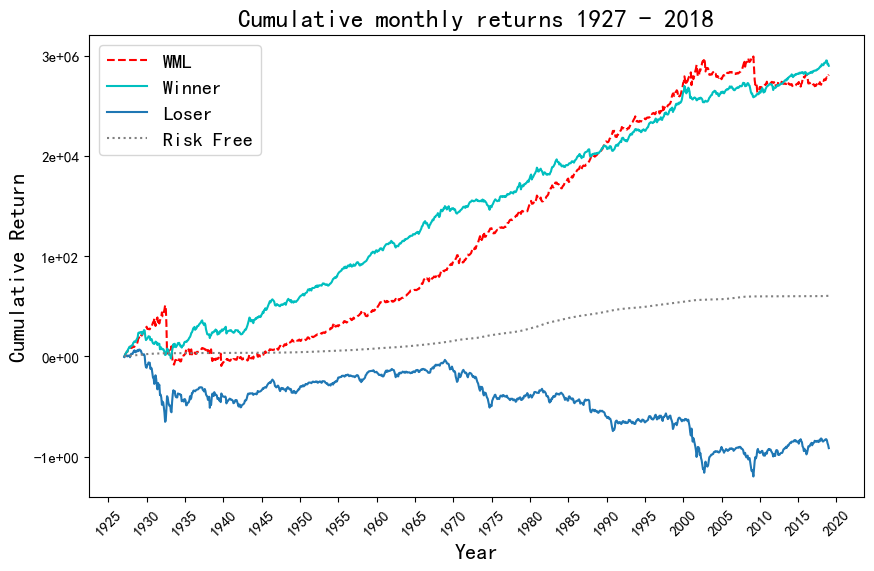

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))
# 绘制累积收益
ax.plot(date, np.cumsum(np.log(1 + WML)), linestyle='--', label="WML", color="red")
ax.plot(date, np.cumsum(np.log(1 + winner_return)), label="Winner", color="c")
ax.plot(date, np.cumsum(np.log(1 + loser_return)), label="Loser")
ax.plot(date, np.cumsum(np.log(1 + rf)), linestyle='dotted', label="Risk Free", color="grey")

ax.set_ylabel("Cumulative Return", fontsize=16, fontweight='bold')
ax.set_xlabel("Year", fontsize=16, fontweight='bold')
ax.set_title("Cumulative monthly returns 1927 - 2018", fontsize=18, fontweight='bold')
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# 设置纵轴刻度标签为小数
ax.set_yticklabels(["{:.0e}".format(x) for x in np.exp(plt.yticks()[0]) -1], fontsize=11)
ax.tick_params(axis='x', labelsize=11, labelrotation=45)
legend = ax.legend(fontsize="x-large")

**分析**
- 从结果来看在正常环境中，持续的价格势头在收益表现上很强劲；
    - 实践中，动量策略的极端回撤（如1930年代、2009年）导致投资者对其实用性产生质疑
    - 在经济危机之后（1929年2008年经济危机之后），糟糕的市场状况改善并且市场开始反弹时，过去表现不好的股票会出现强劲的反弹，因此会导致动量策略的崩溃。

In [83]:
date_sub = date[len(date) - 72 : len(date)]

WML_sub = WML[len(date) - 72 : len(date)]
winner_return_sub = np.array(winner_decile.DM_Ret)[len(date) - 72 : len(date)]
loser_return_sub = np.array(loser_decile.DM_Ret)[len(date) - 72 : len(date)]
rf_sub = np.array(winner_decile.RF)[len(date) - 72 : len(date)]

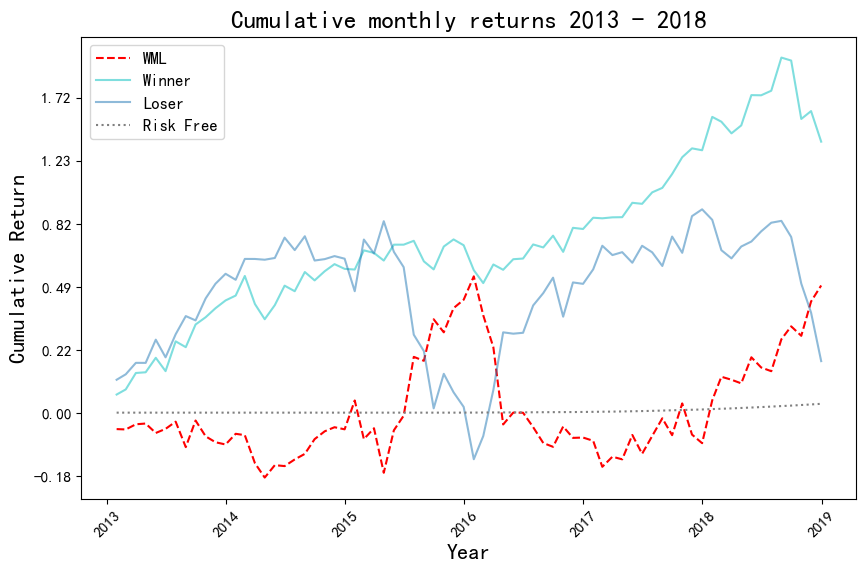

In [84]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(date_sub, np.cumsum(np.log(1 + WML_sub)), linestyle = '--', label = "WML", color = "red")
ax.plot(date_sub, np.cumsum(np.log(1 + winner_return_sub)), label = "Winner", color = "c", alpha = 0.5)
ax.plot(date_sub, np.cumsum(np.log(1 + loser_return_sub)), label = "Loser", alpha = 0.5)
ax.plot(date_sub, np.cumsum(np.log(1 + rf_sub)), linestyle = 'dotted', label = "Risk Free", color = "grey")

ax.set_ylabel("Cumulative Return", fontsize=16, fontweight='bold')
ax.set_xlabel("Year", fontsize=16, fontweight='bold')
ax.set_yticklabels(["{:.2f}".format(x) for x in np.exp(plt.yticks()[0])-1], fontsize=11)
ax.tick_params(axis='x', labelsize=11, labelrotation=45)
ax.set_title("Cumulative monthly returns 2013 - 2018", fontsize=18, fontweight='bold')
legend = ax.legend(fontsize = "large")

### **结论**

- 当观察近期动量策略的投资组合回报时，动量策略显然不像以前那么有效了。这可能是因为低迷的金融市场压低了动量回报策略。  
- 此外，这也可能是因为越来越多的投资者采用动量策略进行交易，而这使得动量交易不像以前那样有利可图。

在健康的金融环境中，正如前面的WML组合描述性统计中所看到的，动量策略可以产生显著而强劲的正回报。但当经济低迷时，动量战略就不再那么有效了。近年来，动量策略表现不佳。需要考虑的**主要挑战**：   
1. 对于动量策略，由于需要经常重新平衡它，需要考虑高交易费；  
2. 此外，这种策略可能包括非流动性的股票，这在执行策略时也可能是一个问题；  
3. 不确定这种策略是否仍然有效。